In [36]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from datetime import date
import matplotlib.pyplot as plt
import mysql.connector
import seaborn as sns

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="p0o9i8u7",
  database="jockey"
)

#file0 = "/Users/apple/Workspace/intelliJ/jockey/regression_20190127.csv"

#dataset0 = pd.read_csv(file0)

#'horse_winCount','jockey_winCount',,'declaredHorseWeight','addedWeight'
#
#features=['draw','horse_winPer','jockey_winPer','horse_newDistance','horse_newHorse',
#         'horse_last4SpeedRate','horse_latestSpeedRate','Days_from_lastRace','weightRadio','weightRD',
#           'horseFx','horseFx_Distance','jockeyFx','jockeyFx_Distance','propByWinOdds']
# 'horse_last4SpeedRate','horse_latestSpeedRate'    
# 'horseFx','jockeyFx','horse_newDistance','horse_newHorse',
features=['drawFx',
         'Days_from_lastRace','weightRadio','horse_last4SpeedRate','horse_latestSpeedRate' ,  
           'horseFx_Distance','jockeyFx_Distance','propByWinOdds']

target_fea='place_edit'
target=[target_fea]
sql = 'select raceDate,raceSeqOfDay,distance,raceClass, horseId, place,lbs,winOdds,'
for aFeature in features:
    sql = sql + aFeature +", "
#sql = sql+ target_fea+ " from racecard"
sql = sql+ " (case when place =1 then 1 when (place <7 & place >1) then 2 else 3 end) as place_edit from racecard" 
sql = sql+" where racemeeting ='ST' and raceclass =4 and distance=1200 and course ='ALL WEATHER TRACK'"

columns=['raceDate','raceSeqOfDay','distance','raceClass',*features,*target]

dataset0 = pd.read_sql(sql,mydb)
#print(dataset0)
#allDates =['20190217']
allDates= dataset0.raceDate.unique()
allDates.sort()
tableName='racecard'


from time import gmtime, strftime
updatedate = strftime("%Y%m%d%H%M%S", gmtime())

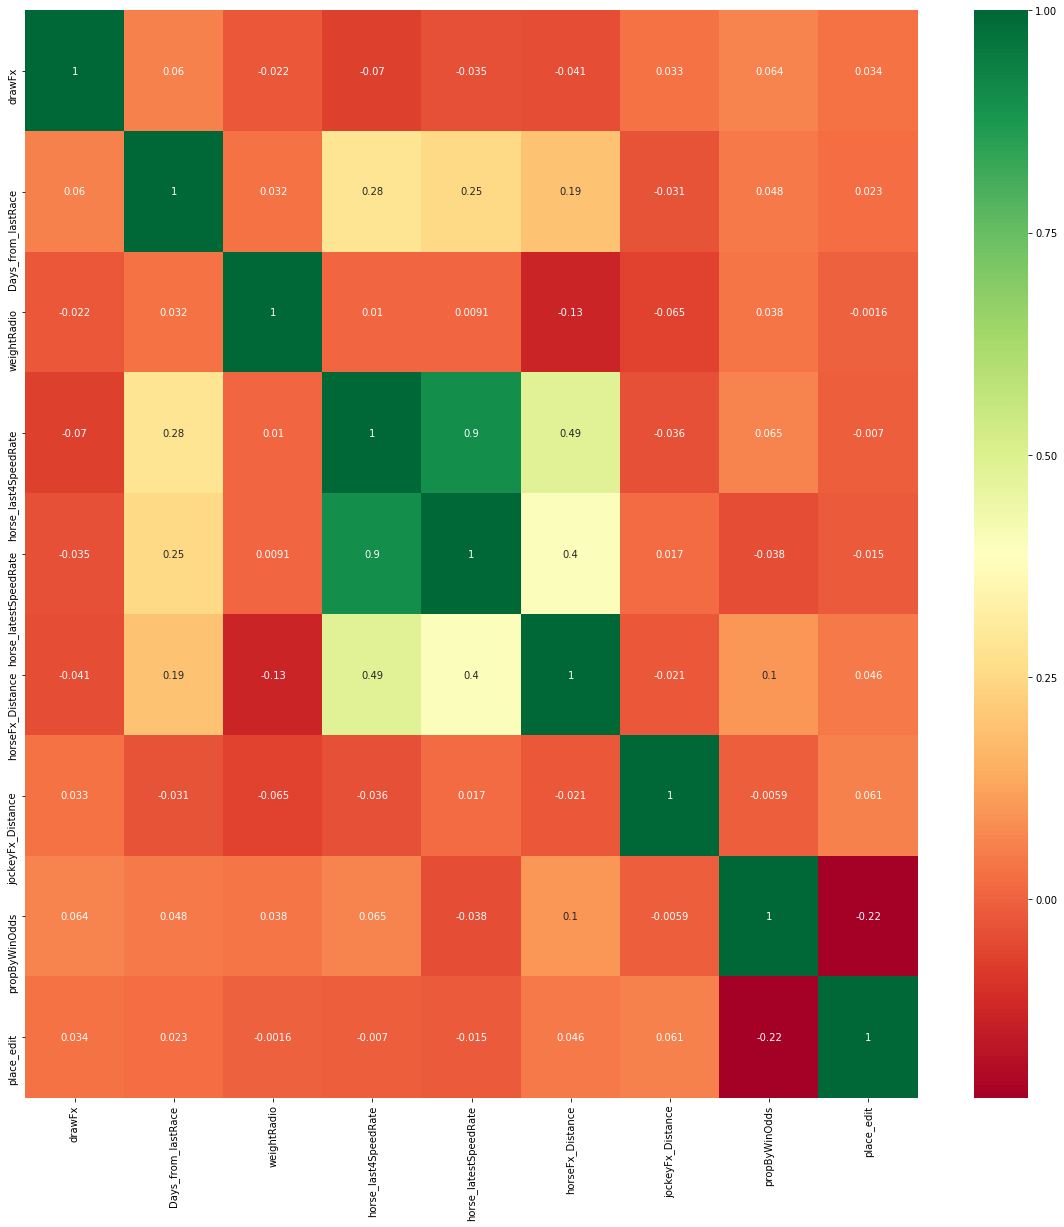

In [37]:
features2 = features + target
corrmat = dataset0[features2].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataset0[top_corr_features].corr(),annot=True,cmap="RdYlGn")

[[ 1.53119588e-01 -4.05044847e-04  3.20979258e+00  3.31237378e-03
  -1.97594123e-03  5.74784690e-02  1.79412245e-01 -1.62975460e-01]]


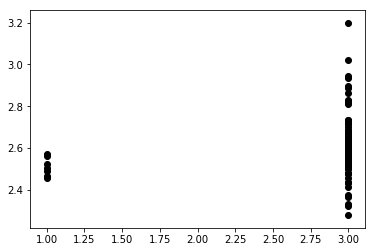

Variance score: -0.14


0.027325078570782257

In [38]:
 #regression model of lbw or finishTime


dataset_train = dataset0[(dataset0['raceDate'] <= '20190201')]
dataset_test =  dataset0[(dataset0['raceDate'] > '20190201')]

X_train=dataset_train[features]
y_train=dataset_train[target] #lbw

X_test=dataset_test[features]
y_test=dataset_test[target] #lbw


reg = lm.LinearRegression() # -0.1
#reg = lm.Ridge(alpha=.5) # -0.1
reg.fit(X_train,y_train)
y_test_predicted=reg.predict(X_test)

print(reg.coef_)

plt.scatter(y_test, y_test_predicted,  color='black')
plt.show()
#print("Mean squared error: %.2f"
#        % mean_squared_error(y_test, y_test_predicted))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_test_predicted))
#print('explained_variance_score score: %.2f' % explained_variance_score(y_test, y_test_predicted))
explained_variance_score(y_test, y_test_predicted)


In [39]:
df = pd.DataFrame(data=y_test_predicted, index=y_test.index,columns=['finishTime_predicted'])
dataset_test_toshow=dataset_test[['raceDate','raceSeqOfDay','distance','raceClass','horseId',
                                  'place','lbs',target_fea]]
dataset_test_withPredicted=dataset_test_toshow.merge(df,how='inner',left_index=True,right_index=True)
dataset_test_withPredicted = dataset_test_withPredicted.sort_values(['raceDate','raceSeqOfDay','finishTime_predicted'])
#print(dataset_test_withPredicted)

predicted_place=1
previous_raceDate=''
previous_seq=''
for index, row in dataset_test_withPredicted.iterrows():
    mycursor = mydb.cursor()
    raceDate_str = str(row['raceDate'])
    raceSeqOfDate =str(row['raceSeqOfDay'])
    horseId = str(row['horseId'])
    finishTime_predicted =str(row['finishTime_predicted'])
    
    if previous_raceDate !='' and previous_raceDate != raceDate_str :
        predicted_place = 1
    elif previous_seq !='' and previous_seq != raceSeqOfDate :
        predicted_place = 1
    print(raceDate_str +' '+ raceSeqOfDate + ' '+ str(predicted_place))
    previous_raceDate = raceDate_str
    previous_seq = raceSeqOfDate
    ##print("Andrea:",raceDate_str,raceSeqOfDate,horseId,finishTime_predicted)
    sql = ("UPDATE "+tableName+ " SET predicted_date=" + updatedate +", predicted_place="+ str(predicted_place) +", predicted_finishTime = "+ finishTime_predicted +
    " WHERE raceDate = "+ raceDate_str + " and raceSeqOfDay = "+raceSeqOfDate + " and horseId ='"+horseId+ "' ")

    #print(predicted_place)
    predicted_place =predicted_place+1
    #print(sql)
    mycursor.execute(sql)
    mydb.commit()
    #print(mycursor.rowcount, " record(s) updated" ,row['raceSeqOfDay'] ,",", row['horseId'] )

   # print("total record:", count)

20190210 4 1
20190210 4 2
20190210 4 3
20190210 4 4
20190210 4 5
20190210 4 6
20190210 4 7
20190210 4 8
20190210 4 9
20190210 4 10
20190210 4 11
20190210 4 12
20190310 6 1
20190310 6 2
20190310 6 3
20190310 6 4
20190310 6 5
20190310 6 6
20190310 6 7
20190310 6 8
20190310 6 9
20190310 6 10
20190310 6 11
20190310 6 12
20190310 7 1
20190310 7 2
20190310 7 3
20190310 7 4
20190310 7 5
20190310 7 6
20190310 7 7
20190310 7 8
20190310 7 9
20190310 7 10
20190310 7 11
20190310 7 12
20190324 4 1
20190324 4 2
20190324 4 3
20190324 4 4
20190324 4 5
20190324 4 6
20190324 4 7
20190324 4 8
20190324 4 9
20190324 4 10
20190324 4 11
20190324 4 12
20190403 4 1
20190403 4 2
20190403 4 3
20190403 4 4
20190403 4 5
20190403 4 6
20190403 4 7
20190403 4 8
20190403 4 9
20190403 4 10
20190403 4 11
20190403 4 12
20190403 6 1
20190403 6 2
20190403 6 3
20190403 6 4
20190403 6 5
20190403 6 6
20190403 6 7
20190403 6 8
20190403 6 9
20190403 6 10
20190403 6 11
20190403 6 12
20190422 4 1
20190422 4 2
20190422 4 3
2019042